# Rigid and perspective transformation in homogeneous coordinates systems

In [1]:
import cv2
import numpy as np
import pandas 
import skimage
import matplotlib.pyplot as plt 
import week1 as w1

### 2.1  Apply Rotation, Translation and skewness.

#### Assume that f = 600, α = 1, β = 0, and δx = δy = 400. Given a traditional camera, what is the resolution in pixels?

**Resolution = 800px800p** (columns, rows)

δx = 800/2 = 400 

δy = 800/2 = 400 

In [2]:
f = 600
alpha = 1
beta = 0 
d_x = d_y = 400
R = np.matrix(np.eye(3))
t = np.array([0, 0.2, 1.5])
K = np.matrix([[f, beta*f, d_x],[0, alpha*f, d_y],[0, 0, 1]])


In [3]:
A = w1.box3d(16)
A.shape

(3, 224)

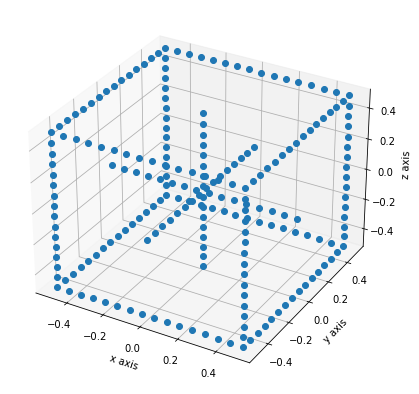

In [4]:
w1.plot3d(A)

In [5]:
a3, a2, Pm = w1.projectpoints(K, R, t, A)

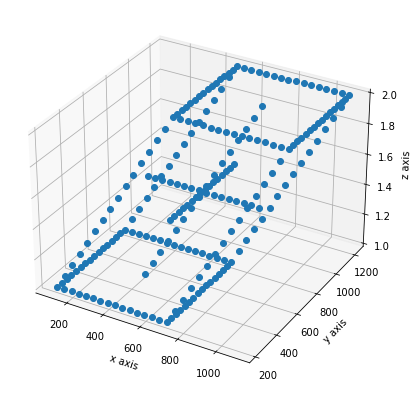

In [6]:
w1.plot3d(a3)

#### Which point are not captured by the image sensor? 
We have to take into account our camera resolution, in this case is 800px800p. So every point that's outside this bound won't be captured by the image.

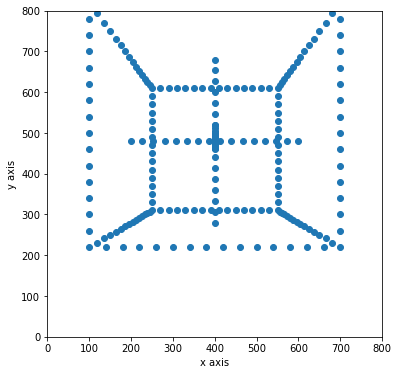

In [7]:
w1.plot2d(a2, lim=(0,800))

#### Indeces of the points that are not in the scope of the image

In [8]:
outliers = [np.where(a2>=800)]
outliers

[(array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64),
  array([ 45,  64,  69,  74,  79,  84,  89,  94, 131, 136, 141, 146, 151,
         156, 161, 208], dtype=int64))]

####  Where does the point [-0.5,-0.5,-0.5] projcts

In [9]:
p1 = np.matrix(np.array([[-0.5],[-0.5],[-0.5]]))

In [10]:
p1_3, p1_2, _ = w1.projectpoints(K, R, t, p1)
p1_2

matrix([[100.],
        [220.]])

**distCoeffs** list that stores the distorsion coefficients. [k3, k5, k7, k8...]

In [11]:
def tylor(rad, coe):
    deltar= []
    c = range(2,100,2)[0:len(coe)]
    for r in rad:
        b = np.array([r**i for i in c])
        deltar.append(sum( coe * b))

    return np.array(deltar)

In [12]:
f = 600
alpha = 1
beta = 0 
d_x = d_y = 400
R = np.matrix(np.eye(3))
t1 = np.array([[0, 0.2, 1.5]]).T
K = np.matrix([[f, beta*f, d_x],[0, alpha*f, d_y],[0, 0, 1]])
dc = [-0.2]

In [13]:
def projection_2Dr(K, R, t, P, dcoef):
    
    # Concatenate the rotation matrix "R" and the tranlation array "t"
    R = np.concatenate((R,t), axis=1)
    # Get the shape of the matrix P 
    _,n = P.shape
    # Add a 4th row on the matrix points full of ones.
    P = np.vstack([P, np.ones((1,n))])
    q = R@P
    # Get the scale so after applying the distorsion we can multiply it 
    s = np.array(q[2,:])
    # Create the 2d array and divide it by the scale
    q = np.array(q[0:2,:])/s
    #Calculate the radius 
    r = np.sqrt(q[0,:]**2 + q[1,:]**2)
    # Calculate tylor expansion 
    t = tylor(r, dcoef)
    # Apply distorsion formula 
    dist_q = q * (1+t)
    # Add ones to the third dimension and multiply by the scale 
    dist_q = np.matrix(np.vstack([dist_q, np.ones((1,n))]) * s)
    # Multiply by the camera matrix
    dist_q3d = np.array(K@dist_q)
    # Obtain the 2d projection by dividing it by the 3th dime
    dist_q2d = dist_q3d[:2,:]/dist_q3d[2,:]
    
    return dist_q3d, dist_q2d


b3, b2 = projection_2Dr(K,R,t1,A,dc)

p13d, p12d = projection_2Dr(K,R,t1,p1,dc)
p12d

array([[120.4 ],
       [232.24]])

#### Which point are not captured by the image sensor? 
We have to take into account our camera resolution, in this case is 800px800p. So every point that's outside this bound won't be captured by the image.

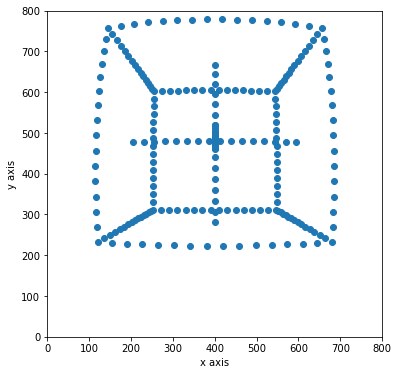

In [14]:
w1.plot2d(b2, lim=(0,800))

In [15]:
outliers = [np.where(b2>=800)]
outliers

[(array([], dtype=int64), array([], dtype=int64))]

Yes all the points are catured by the camera 

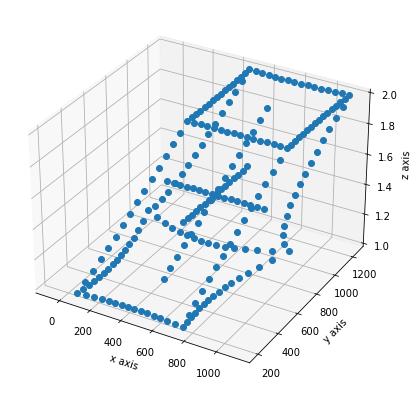

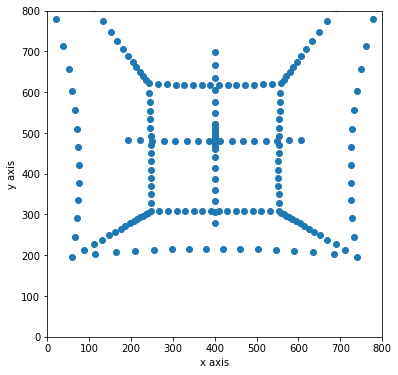

In [16]:
dc = [0.2, 0.4, 0.5]

c3, c2 = projection_2Dr(K,R,t1,A,dc)


w1.plot3d(c3)
w1.plot2d(c2, lim=(0,800))

# Exercise 2.3

In [17]:
f = 0.455732
alpha = 1
beta = 0 
d_x = d_y = 400
R = np.matrix(np.eye(3))
t1 = np.array([[0, 0.2, 1.5]]).T
K = np.matrix([[f, beta*f, d_x],[0, alpha*f, d_y],[0, 0, 1]])
dc = [-0.2]

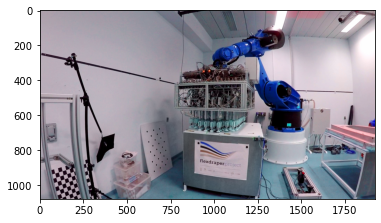

In [18]:
image = cv2.imread("gopro_robot.jpg")
plt.imshow(image)

In [19]:
image.shape

(1080, 1920, 3)

As definition, the principal points δx and δy are the center of the image. As there's no skewness, alpha should be 1 and beta 0.
Aditionally, the focal length is: f*width

In [20]:
height, width,_ = image.shape
f = 0.455732 * width
d_x = width/2
d_y = height/2 
alpha = 1
beta = 0 
K = np.matrix([[f, beta*f, d_x],[0, alpha*f, d_y],[0, 0, 1]])
K

matrix([[875.00544,   0.     , 960.     ],
        [  0.     , 875.00544, 540.     ],
        [  0.     ,   0.     ,   1.     ]])

# Homography

Relate two points on a plane

In [21]:
def convert(H,P):
    """
    H: Homography Matrix 
    p: point in 2 dimensions 
    """    
    m,n = P.shape
    # Obtain number of columns we want to cast. In case is one point or a matrix of points
    if m == 2:
        col = n
    else:
        col = m
    # In case it doesn't have the desired shape, transpose it
    if P.shape != (2,col):
        P = P.T
    if col == 1:
        P = np.matrix(np.vstack([P, col]))
    else:
        P = np.matrix(np.vstack([P, np.ones((1,col))]))

    Q = H@P
    Q = Q[:2]/Q[2]
    
    return Q

In [30]:
H = np.matrix(np.array([[-2, 0, 1], [1, -2, 0], [0, 0, 3]]))
p1 = np.array([[1, 1]])
p2 = np.array([[0, 3]])
p3 = np.array([[2, 3]])
p4 = np.array([[2, 4]])
print(H)

[[-2  0  1]
 [ 1 -2  0]
 [ 0  0  3]]


In [23]:
q1 = convert(H, p1)
q2 = convert(H, p2)
q3 = convert(H, p3)
q4 = convert(H, p4)
q1.shape

(2, 1)

In [24]:
P = np.concatenate([p1.T, p2.T, p3.T, p4.T], axis = 1)
Q = np.array(np.concatenate([q1.T, q2.T, q3.T, q4.T], axis=1))

# Norm function 

P2n = T$*$P2 <br>
P1n = H$*$P2n 

P1n = H$*$T$*$P2 <br>
P1n = T$*$P1 <br> 
T^-1$*$P1n = P1 

P1 = inv(T)$*$H$*$T$*$P2


In [25]:
def normalize2d(P):
    mu_x, mu_y = np.mean(P, axis=1)
    std_x, std_y = np.std(P, axis=1)
    
    T = np.matrix(np.array([[1/std_x, 0, -mu_x/std_x], [0, 1/std_y, -mu_y/std_y],[0, 0, 1]]))
    return T

# Given a set of points and it's mapping points q compute H
We need at least 4 pairs of points to estimate the homography, as it has 8 degrees of freedom. <br>
Maps 2 points in 2D

In [31]:
def matrix_b(p1, q1):
    # both points, p1 and q2 are in inhomogenous coordinates.
    # Create the Skeweness matrix [p1]x
    p1_matrix = np.matrix(np.array([[0, -1, p1[1]],[1, 0, -p1[0]],[-p1[1], p1[0], 0]]))
    # Append 1 to the point q. So we can create krockener Product
    q1 = np.append(q1, 1)
    for i in range(len(q1)):
        
        if not i:
            Q = q1[i] * p1_matrix
        else:
             Q = np.concatenate((Q, q1[i]*p1_matrix),1)
    return Q

In [32]:
def hest(p1, p2, p3, p4, q1, q2, q3, q4):
    m,n = p1.shape
    # Obtain number of columns we want to cast. In case is one point or a matrix of points
    if m == 2:
        P = np.concatenate([p1, p2, p3, p4], axis = 1)
    else:
        P = np.concatenate([p1.T, p2.T, p3.T, p4.T], axis = 1)
    r,c = q1.shape
    if r == 2:
        Q = np.array(np.concatenate([q1, q2, q3, q4], axis=1))
    else:
        Q = np.array(np.concatenate([q1.T, q2.T, q3.T, q4.T], axis=1))
    _,n = P.shape

    for i in range(n):
        if not i:
            B = matrix_b(Q[:,i],P[:,i])
        else:
            B = np.concatenate([B, matrix_b(Q[:,i], P[:,i])])
    
    # Calculate the norm matrix T
    T =  normalize2d(P)
   
    # Estimation of H
    # Apply singular value decomposition: Scores are the projections into the principal components. S is the square root of the
    # the eigenvalues. Eigenvec are the Eigen Vectors.
    
    scores, s, eigenvec = np.linalg.svd(B)
    # Find the min Eigenvalue
    idx = np.where(s==min(s))
    # Select the eigenvector correspondent to the eigenvalue
    H = eigenvec[idx]
    # Reshape the array into a matrix form 
    H = H.reshape((3,3), order='F')
   
    # Apply The norm matrix T to H. ***I'm not sure if should be T x H or the other way arround.
    TH = T@H
    
    return TH, T, H

In [33]:
TH, _, H = hest(p1,p2,p3,p4,q1,q2,q3,q4)
H

matrix([[ 4.58831468e-01, -6.25564151e-17, -2.29415734e-01],
        [-2.29415734e-01,  4.58831468e-01,  4.59550987e-16],
        [ 6.03657937e-18, -3.77671296e-18, -6.88247202e-01]])

In [34]:
# Select the last value to scale it 
s = H[-1,-1]
# Scale it 
H = np.round(H/s*3)
H

matrix([[-2.,  0.,  1.],
        [ 1., -2., -0.],
        [-0.,  0.,  3.]])

### Generate 100 random 2D points and a homography matrix
We can generate random homography matrices as follows: https://medium.com/@nutella50g/dataset-augmentation-with-random-homographies-a8f4b44830d4

In [35]:
theta = 37*np.pi/180
T_x = 2
T_y = 4
sx = 2
sy = 1.5
p_1 = 3
p_2 = 4
He = np.matrix(np.array([[np.cos(theta), -np.sin(theta), T_x], [np.sin(theta), np.cos(theta), T_y], [0, 0, 1]]))
Ha = np.matrix(np.array([[1, sy, 0], [sx, 1, 0], [0, 0, 0]]))
Hp = np.matrix(np.array([[1, 0, 0], [0, 1, 0], [p_1, p_2, 1]]))
H = He@Ha@Hp

In [36]:
P2d = np.array([np.random.randint(0,20,100), np.random.randint(0,20,100)])
H = np.matrix(np.random.randint(0,5,9).reshape(3,3))
H

matrix([[2, 0, 4],
        [3, 2, 3],
        [1, 3, 4]])

In [37]:
Q2 = convert(H, P2d)

In [38]:
p21 = np.expand_dims(P2d[:,0], axis =1)
p22 = np.expand_dims(P2d[:,1], axis =1)
p23 = np.expand_dims(P2d[:,2], axis =1)
p24 = np.expand_dims(P2d[:,3], axis =1)
q21 = Q2[:,0]
q22 = Q2[:,1]
q23 = Q2[:,2]
q24 = Q2[:,3]

In [52]:
q = np.array([0.625, 1.328125])
Q = np.array([18, 14])
print(matrix_b(q,Q).T)


[[  0.         0.625     -8.75    ]
 [ -0.625      0.        11.25    ]
 [  8.75     -11.25       0.      ]
 [  0.         1.328125 -18.59375 ]
 [ -1.328125   0.        23.90625 ]
 [ 18.59375  -23.90625    0.      ]
 [  0.         1.       -14.      ]
 [ -1.         0.        18.      ]
 [ 14.       -18.         0.      ]]


In [36]:
TH,T,H1 = hest(p21,p22,p23,p24,q21,q22,q23,q24)
s = H1[-1,-1]
np.round(H1/s*H[-1,-1])
T

matrix([[ 0.43905704,  0.        , -0.98787834],
        [ 0.        ,  0.52075564, -1.95283366],
        [ 0.        ,  0.        ,  1.        ]])

The homagraphy matrix has the same value, but if we multiply it by the T matrix, it's not the same anymormore

In [51]:
P2d = np.array([np.random.randint(0,20,100), np.random.randint(0,20,100)])
P2d.shape

(2, 100)

In [39]:
T = normalize2d(P2d)
T

matrix([[ 0.17032538,  0.        , -1.72028631],
        [ 0.        ,  0.16910358, -1.69272685],
        [ 0.        ,  0.        ,  1.        ]])

In [41]:
def normalize2d_3d(p,d):
    x=np.array([p[:,0],np.ones(len(p))])
    y=np.array([p[:,1],np.ones(len(p))])

    mu_x= np.mean(p[:,0])
    mu_y= np.mean(p[:,1])
    
    std_x= np.std(p[:,0])
    std_y= np.std(p[:,1])
    
    #Tranformation matrix
    T_x= np.array([[1/std_x, -mu_x/std_x]])
    T_y= np.array([[1/std_y, -mu_y/std_y]])
    
    x_norm=(T_x@x).T
    y_norm=(T_y@y).T

    points_norm=np.column_stack((x_norm,y_norm))
    T_z=1
    
    if d==3:
        z=np.array([p[:,2],np.ones(len(p))])
        mu_z= np.mean(p[:,2])
        std_z= np.std(p[:,2])
        T_z= np.array([[1/std_z, -mu_z/std_z]])
        z_norm=(T_z@z).T
        points_norm=np.column_stack((points_norm,z_norm))
    
    return T_x,T_y,T_z,points_norm

In [102]:
P2d = np.array([np.random.randint(0,20,100), np.random.randint(0,20,100)])

In [104]:
T_x, T_y, T_z, p = normalize2d_3d(P2d.T, 2)
p[0:10,:]

array([[-1.23065742, -1.10362184],
       [ 0.27243561, -0.75158936],
       [-0.10333765,  1.36060556],
       [ 0.27243561,  0.83255683],
       [ 0.27243561,  0.3045081 ],
       [ 1.39975539,  0.12849186],
       [-0.29122428, -1.45565433],
       [ 0.46032224, -1.27963808],
       [-1.79431731, -0.22354063],
       [ 0.27243561, -0.9276056 ]])

In [105]:
m,n = P2d.shape
T = normalize2d(P2d)

In [106]:
P2dh = np.vstack([P2d, np.ones((1,n))])
N = T@P2dh
N.T[0:10,:]


matrix([[-1.23065742, -1.10362184,  1.        ],
        [ 0.27243561, -0.75158936,  1.        ],
        [-0.10333765,  1.36060556,  1.        ],
        [ 0.27243561,  0.83255683,  1.        ],
        [ 0.27243561,  0.3045081 ,  1.        ],
        [ 1.39975539,  0.12849186,  1.        ],
        [-0.29122428, -1.45565433,  1.        ],
        [ 0.46032224, -1.27963808,  1.        ],
        [-1.79431731, -0.22354063,  1.        ],
        [ 0.27243561, -0.9276056 ,  1.        ]])

In [107]:
P2dh.shape

(3, 100)

In [234]:
def normalize2(P, scale:int=None):
    """
    Given a set of points, Estimates the T matrix which standarizes these points. The given points have to be in Homogenous 
    form. It follows the following equation:
    
    z = (x-mu_x)/std_x
    
    Can work with all dimensions.
    """
    # calculate the means and unpack them in lists
    *mus, = np.mean(P, axis=1)
    *std, = np.std(P, axis=1)
    # Transform lists into arryas so we can operate with them 
    mus = np.array(mus)
    std = np.array(std)
    # Create the T matrix
    T = np.column_stack([np.diag(1/std),mus/std])
    # If we want to perserve the scale:
    if scale:
        f = np.zeros((T.shape[1]))
        f[-1] = 1
        T = np.vstack((T,f))
    return T

In [239]:
T =normalize2(P2d)
P2d.shape

(2, 100)

In [157]:
np.diag(m)

array([[9.55, 0.  ],
       [0.  , 9.27]])

#### How to deal with normalization 

P2n = T*P2
P1n = H*P2n 

P1n = H*T*P2
P1n = T*P1 
T^-1*P1n = P1

P1 = inv(T)*H*T*P2
